# **Proyecto del Curso: Clasificación de aptitud para la producción de Café en el departamento del Huila**
### Universidad Nacional de Colombia
### Programación SIG
### Integrantes:
* Cristian Santiago Acuña Ramírez
* Avdoni Sánchez Reinoso
    - Estudiantes de Maestría en Geomática

## 🎯 Objerivo: 

📜 El presente cuaderno de trabajo en JupyterLab tiene como objetivo principal identificar y clasificar las áreas con mayor potencial productivo para el cultivo de café, a partir de un análisis espacial y temático de aptitud del suelo. Para ello, se estructura un flujo de trabajo dividido en varias secciones que permiten una evaluación progresiva y fundamentada. Inicialmente, se selecciona el departamento con mayor relevancia en términos de producción cafetera a nivel nacional. Posteriormente, se realiza una clasificación preliminar de la aptitud del suelo en tres categorías (Alta, Media y Baja), integrando variables agronómicas clave. 

📊 A esta clasificación se le incorpora un análisis logístico que considera aspectos como el acceso a la red vial, la cercanía a estaciones climáticas y la disponibilidad de mano de obra, con el fin de ajustar la aptitud en función de las condiciones reales de acceso y operación. Finalmente, se excluyen aquellas áreas con restricciones legales o ambientales —como zonas de conservación, áreas protegidas o territorios con uso restringido—, con el propósito de garantizar que las zonas identificadas sean viables desde el punto de vista normativo. El resultado final se representa cartográficamente, consolidando una evaluación espacial de la aptitud del suelo para el cultivo de café en el departamento seleccionado.

### **1. Intalación de librerías.** 
En esta sección se integra el conjunto de librerías que se utilizarán para este proyecto.

In [187]:
# ========================
# 📦 Importación de librerías
# ========================

# -- Importaciones estándar --
import os  # Interacción con el sistema operativo (rutas, carpetas, etc.)
import glob  # Búsqueda de archivos que cumplan un patrón específico
import numpy as np  # Operaciones matemáticas y manejo eficiente de arrays
import pandas as pd  # Herramientas para análisis y manipulación de datos tabulares

# -- Librerías de visualización --
import matplotlib.pyplot as plt  # Librería principal para crear gráficos y visualizaciones
import matplotlib.cm as cm  # Acceso a mapas de colores predefinidos para visualizaciones
import matplotlib.colors as colors  # Definición y manejo de mapas de colores personalizados
import matplotlib.patches as mpatches  # Crear objetos gráficos como leyendas personalizadas o símbolos

# -- Librerías geoespaciales --
import geopandas as gpd  # Permite trabajar con datos geoespaciales como si fueran DataFrames de pandas
import fiona  # Lectura y escritura de archivos geoespaciales (shapefiles, geopackage, etc.)
import shapely  # Manipulación y análisis de geometrías (puntos, líneas, polígonos)
import contextily as cx  # Agrega mapas base (tiles) a gráficos geoespaciales (como OpenStreetMap)
import contextily as ctx  # (Alias alternativo) para agregar mapas base en sistemas de coordenadas proyectadas

# -- Earth Engine y análisis raster --
import ee  # Earth Engine Python API: acceso a datasets y análisis de Google Earth Engine
import geemap  # Simplifica la interacción con Earth Engine y permite exportar imágenes ráster
import rasterio  # Lectura, escritura y manipulación de archivos ráster con metadatos geoespaciales
import rasterio.plot  # Funciones para visualizar datos ráster (como show() y show_hist())
import rasterstats  # Estadísticas zonales sobre ráster usando geometrías vectoriales
from rasterio.plot import show  # Función para visualizar rásters desde rasterio
from rasterio.io import MemoryFile  # Permite trabajar con archivos ráster en memoria
from rasterio.merge import merge  # Combina múltiples rásters en uno solo
from rasterio import Affine  # Manejo de transformaciones espaciales en ráster
from rasterio.crs import CRS  # Definición y transformación del sistema de referencia de coordenadas
from rasterio.transform import from_bounds  # Crear transformaciones espaciales a partir de límites geográficos

# -- IPython y visualización en Jupyter --
from IPython.display import display, HTML  # Mostrar objetos HTML en notebooks

# -- Matplotlib avanzado --
from matplotlib.lines import Line2D  # Crear y personalizar líneas en leyendas o anotaciones
from matplotlib.colors import Normalize  # Normaliza valores para mapas de color

# -- Shapely geométrico --
from shapely.geometry import Point  # Crear objetos de tipo punto
from shapely.ops import unary_union  # Une múltiples geometrías en una sola
from shapely.ops import nearest_points  # Encuentra el punto más cercano entre dos geometrías

# -- Manejo de archivos --
from pathlib import Path  # Manejo orientado a objetos de rutas de archivos

# -- Funciones de fuente --
from src.clasificacion_aptitud import (clasificar_profundidad, clasificar_textura, clasificar_drenaje, clasificar_temperatura, clasificar_precipitacion, clasificar_pendiente, clasificar_distancia, clasificar_distancia_estacion, calcular_apt_final)

from src.export_cell import (export_cell, export_cell_Clim)

# ========================
# 📁 Creación de carpeta para guardar figuras
# ========================
os.makedirs("Results/Maps", exist_ok=True)  # Crea una carpeta para guardar figuras, si no existe

### **2. Carga de archivos de entrada (Preparación de los datos)**
#### **2.1 Rutas de entrada:** 
* En la siguiente sección se definen las rutas de acceso para los diferentes insumos que se van a utilizar en este proyecto:

In [188]:
# Rutas de los archivos

root_folder=r"/database" # Ruta de carpeta general

# Rutas a los archivos de entrada (Insumos)
shp_mun = root_folder + '/municipios/municipios_colombia.shp' # Shape de Municipios de Colombia
shp_frnt_agr = root_folder + '/frontera_agricola_abr2024/Frontera_Agricola_Abr2024.shp' # Shape de Fronteras Agrícolas
shp_runap = root_folder + '/runap/runap2Polygon.shp' # Shape Runap
CSV_inf_suel_hul = root_folder + '/Info_suelos_huila.csv' # Información adicional de suelos del huila
CSV_EVA = root_folder + '/EVAs_2019_2024.xlsx' # CSV de Evaluaciones Agropecuarias de 2019 - 2024
CSV_EST = root_folder + '/Catalogo_Estaciones_IDEAM.csv' # Estaciones Meteorológicas registradas por el IDEAM
gbd_vias = root_folder + '/red_vial.gdb'  # archivo tipo GeoPackage de Vías Nacionales
gbd_suel_huil = root_folder + '/SUELOS_HUILA_100K.gdb'  # archivo tipo GeoPackage de Características de los suelos del Huila

print("Titulos de archivo de Vias Nacionales:\n", fiona.listlayers(gbd_vias), "\n")
print("Titulos de archivo de Suelos Huila:\n", fiona.listlayers(gbd_suel_huil))
print(fiona.listlayers(CSV_inf_suel_hul))

Titulos de archivo de Vias Nacionales:
 ['Via', 'Puente_L', 'Puente_P', 'Tunel', 'VFerre', 'LVia', 'SVial', 'T_1_DirtyAreas', 'T_1_PointErrors', 'T_1_LineErrors', 'T_1_PolyErrors'] 

Titulos de archivo de Suelos Huila:
 ['SUELOS_HUILA_100K_VF_20191001', 'T_1_DirtyAreas', 'T_1_PointErrors', 'T_1_LineErrors', 'T_1_PolyErrors']
['Info_suelos_huila']


#### **2.2 Lectura, corrección y proyección de datos:** 
* En la siguiente sección de código se leen los archivos, se proyectan y en el caso de las estaciones se convierte en tipo GeoDataFrame.

In [3]:
# Se cargan y se proyectan las entradas que son de tipo espacial.

# 2.2.1 Municipios
gdf_mun = gpd.read_file(shp_mun)
if gdf_mun.crs is None:
    gdf_mun.set_crs(epsg=4326, inplace=True)
gdf_mun = gdf_mun.to_crs(epsg=9377)

# 2.2.2 Frontera agrícola
gdf_frnt_agr = gpd.read_file(shp_frnt_agr)
if gdf_frnt_agr.crs is None:
    gdf_frnt_agr.set_crs(epsg=4326, inplace=True)
gdf_frnt_agr = gdf_frnt_agr.to_crs(epsg=9377)

# 2.2.3 Runap
gdf_runap = gpd.read_file(shp_runap, encoding='latin1')
if gdf_runap.crs is None:
    gdf_runap.set_crs(epsg=4326, inplace=True)
gdf_runap = gdf_runap.to_crs(epsg=9377)

# 2.2.4 Suelos Huila en escala 100K
gdf_suelos = gpd.read_file(gbd_suel_huil, layer="SUELOS_HUILA_100K_VF_20191001")
if gdf_suelos.crs is None:
    gdf_suelos.set_crs(epsg=4326, inplace=True)
gdf_suelos = gdf_suelos.to_crs(epsg=9377)

# 2.2.5 Cargar red vial (capa "Via" dentro del GeoPackage)
vias_col = gpd.read_file(gbd_vias, layer="Via")
if vias_col.crs is None:
    vias_col.set_crs(epsg=4326, inplace=True)
vias_col = vias_col.to_crs(epsg=9377)

# 2.2.6 Carga de archivo CSV de Información Adicional de suelos

df_inf_suel = pd.read_csv(CSV_inf_suel_hul, encoding='utf-8', sep = ";")

# 2.2.7 Carga de archivo CSV Evaluaciones Agropecuarias entre 2019 y 2014 (EVAs 2019-2014)

df_evas = pd.read_excel(CSV_EVA)
df_evas = df_evas.rename(columns={'Código Dane municipio': 'COD_MUNI'})
df_evas['COD_MUNI'] = df_evas['COD_MUNI'].astype(str).str.zfill(5)

# 2.2.8 Cargar archivo CSV de estaciones IDEAM y convertirlo en GeoDataFrame
df_est = pd.read_csv(CSV_EST)

    # - Nombre de la columna que guarda la coordenada en formato "(lat, lon)"
coord_col = "Ubicación"      

    # --> 1. Extraer latitud y longitud como dos columnas numéricas
coords = (
    df_est[coord_col]
      .str.strip("()")            # quitar paréntesis
      .str.split(",", expand=True)  # separar por coma
      .apply(pd.to_numeric)         # convertir a float
)
df_est["lat"] = coords[0]
df_est["lon"] = coords[1]

    # --> 2. Crear geometría punto a partir de lon, lat (EPSG:4326)
gdf_est = gpd.GeoDataFrame(
    df_est,
    geometry=gpd.points_from_xy(df_est["lon"], df_est["lat"]),
    crs="EPSG:4326"
)

    # --> 3. Reproyectar a EPSG:9377
gdf_est = gdf_est.to_crs(epsg=9377)

    # --> 4. Visualización

print("Estaciones IDEAM cargadas:", gdf_est.shape)
display(gdf_est.head())
print("Municipios:", gdf_mun.shape)
print("Red vial:", vias_col.shape)
print("EVAs:\n", df_evas.head())
print("Inf Suelos:\n", df_inf_suel.head())


Estaciones IDEAM cargadas: (8973, 14)


,Codigo,Nombre,Categoria,Estado,Departamento,Municipio,Ubicación,Altitud,Fecha_instalacion,Fecha_suspension,Corriente,lat,lon,geometry
0,52057100,RUMICHACA - AUT [52057100],Limnigráfica,Activa,Nariño,Ipiales,"(0.81378611, -77.66197778)",2582,2016-11-15,NaN,Guaitara,0.813786,-77.661978,POINT (4480921.418 1648261.853)
1,52055170,LA JOSEFINA - AUT [52055170],Climática Principal,Activa,Nariño,Contadero,"(0.93030556, -77.49119444)",2450,2005-12-10,NaN,Guaitara,0.930306,-77.491194,POINT (4499992.408 1661153.867)
2,52055220,EL PARAISO - AUT [52055220],Climática Principal,Activa,Nariño,Túquerres,"(1.07061111, -77.63688889)",3120,2004-03-01,NaN,Guaitara,1.070611,-77.636889,POINT (4483759.028 1676727.973)
3,44015070,EL PEPINO - AUT [44015070],Climática Principal,Activa,Putumayo,Mocoa,"(1.08288889, -76.66711111)",760,2005-11-11,NaN,Guaitara,1.082889,-76.667111,POINT (4591897.597 1677940.612)
4,48015040,PUERTO NARINO - AUT [48015040],Climática Principal,Activa,Amazonas,Puerto Nariño,"(-3.78030556, -70.36263889)",158,2005-07-19,NaN,Amazonas,-3.780306,-70.362639,POINT (5292824.016 1139928.729)


Municipios: (1122, 92)
Red vial: (112322, 9)
EVAs:
    Código Dane departamento Departamento COD_MUNI Municipio  \
0                         5    Antioquia    05001  Medellín   
1                         5    Antioquia    05001  Medellín   
2                         5    Antioquia    05001  Medellín   
3                         5    Antioquia    05001  Medellín   
4                         5    Antioquia    05001  Medellín   

       Desagregación cultivo   Cultivo Ciclo del cultivo Grupo cultivo  \
0  Aguacate demás variedades  Aguacate        Permanente      Frutales   
1  Aguacate demás variedades  Aguacate        Permanente      Frutales   
2  Aguacate demás variedades  Aguacate        Permanente      Frutales   
3  Aguacate demás variedades  Aguacate        Permanente      Frutales   
4  Aguacate demás variedades  Aguacate        Permanente      Frutales   

         Subgrupo   Año Periodo  Área sembrada (ha)  Área cosechada (ha)  \
0  Demás frutales  2019    2019               24

#### **2.3 Preparación de los datos de Google Earth Engine:** 
* Aquí se creará la capa Shape necesaria para clipear la imagen raster que se obtendrá a partir de Google Earth Engine (GEE).
* Se descargan las imágenes de cada raster, se realiza por grilla para optimizar el proceso.
* También se recortará la sección de interés de los raster DEM y Clima.


##### **2.3.1 Área de Interés (aoi)**
* Seleccionamos el área de interés que es el departamento del Huila.

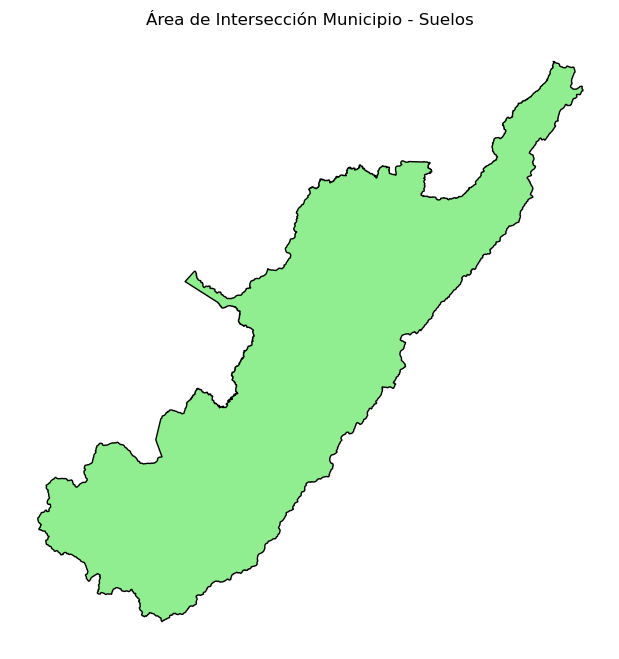

In [190]:
# Procesamiento espacial
muni_suelos = gpd.overlay(gdf_mun, gdf_suelos, how="intersection", keep_geom_type=False)
aoi_geom = muni_suelos.union_all()  # geometría combinada
aoi = gpd.GeoDataFrame(geometry=[aoi_geom], crs=muni_suelos.crs)  # convertir a GeoDataFrame

# Crear figura y eje
fig, ax = plt.subplots(figsize=(8, 8))  # puedes ajustar el tamaño
aoi.plot(ax=ax, color='lightgreen', edgecolor='black')  # estilo opcional

# Título y etiquetas si lo deseas
ax.set_title("Área de Intersección Municipio - Suelos")
ax.set_axis_off()

# Guardar la figura
plt.savefig("Results/Maps/Area_interes.png", dpi=300, bbox_inches="tight")

# Mostrar en notebook (opcional)
plt.show()

##### **2.3.2 Iniciar sesión GEE y Cargar conjunto de imágenes de interés**
* Autenticamos la sesión con Google Earth Engine
* Inicializamos la librería
* Se filtrarán los datos de elevación a partir del archivo DEM de _"NASA SRTM Digital Elevation 30m"_
* Se filtrarán los datos de climad e la base de datos de _"WorldClim BIO Variables V1"_

In [5]:
ee.Authenticate()

Enter verification code:  4/1AVMBsJgIeLs-wP8Zea5rJTd3RxEwn0ixc6q5nDuxZb75-k5SoWQU-OkAaZM



Successfully saved authorization token.


In [7]:
ee.Initialize()

In [8]:
# Use the SRTM DEM (30m resolution) provided by the USGS
dem = ee.Image("USGS/SRTMGL1_003")

# --  Load the CLIM and clip it to the AOI ---
raster_clim = ee.Image("WORLDCLIM/V1/BIO")

#--- Convert the AOI geometry to Earth Engine format ---
huila_wgs84 = aoi.to_crs(epsg=4326)
huila_wgs84.to_file("Huila_wgs84.geojson", driver="GeoJSON")
huila_fc = geemap.geojson_to_ee("Huila_wgs84.geojson")

##### **2.3.3 Crear cuadrícula sobre el departamento del Huila: 4x4**
* Se dividen en 16 subzonales que permitan dividir el trabajo de la descarga de las imágenes raster.

In [9]:
grid = geemap.fishnet(data=huila_fc, rows=4, cols=4)

##### **2.3.4 Visualizar en el mapa**
* Se dividen en 16 subzonales que permitan dividir el trabajo de la descarga de las imágenes raster.

In [10]:
Map = geemap.Map()
Map.addLayer(dem, {}, 'SRTM DEM')
Map.addLayer(grid, {}, 'Grid sobre Huila')
Map.addLayer(huila_fc, {}, 'Huila')
Map.centerObject(huila_fc, 8)
Map

Map(center=[2.570000778222359, -75.5847144578526], controls=(WidgetControl(options=['position', 'transparent_b…

##### **2.3.5 Crear función para exportar raster según celdas**
* Aplicamos una función para filtrar imágenes del DEM.
* También aplicamos función para filtrar imágenes de WorldClim.
* Para cada una asignamos la tarea para GEE.

##### **2.3.6 Exportación de imágenes raster por celda de la cuadrícula**


In [12]:
grid_list = grid.toList(grid.size())
for i in range(grid.size().getInfo()):
    feature = ee.Feature(grid_list.get(i))
    export_cell(feature, i)

Exportando DEMtile0...
Exportando DEMtile1...
Exportando DEMtile2...
Exportando DEMtile3...
Exportando DEMtile4...
Exportando DEMtile5...
Exportando DEMtile6...
Exportando DEMtile7...
Exportando DEMtile8...
Exportando DEMtile9...
Exportando DEMtile10...
Exportando DEMtile11...
Exportando DEMtile12...


In [16]:
grid_list = grid.toList(grid.size())
for i in range(grid.size().getInfo()):
    feature = ee.Feature(grid_list.get(i))
    export_cell_Clim(feature, i)

Exportando Climtile0...
Exportando Climtile1...
Exportando Climtile2...
Exportando Climtile3...
Exportando Climtile4...
Exportando Climtile5...
Exportando Climtile6...
Exportando Climtile7...
Exportando Climtile8...
Exportando Climtile9...
Exportando Climtile10...
Exportando Climtile11...
Exportando Climtile12...


##### **2.3.7 Visualización del DEM recortado**

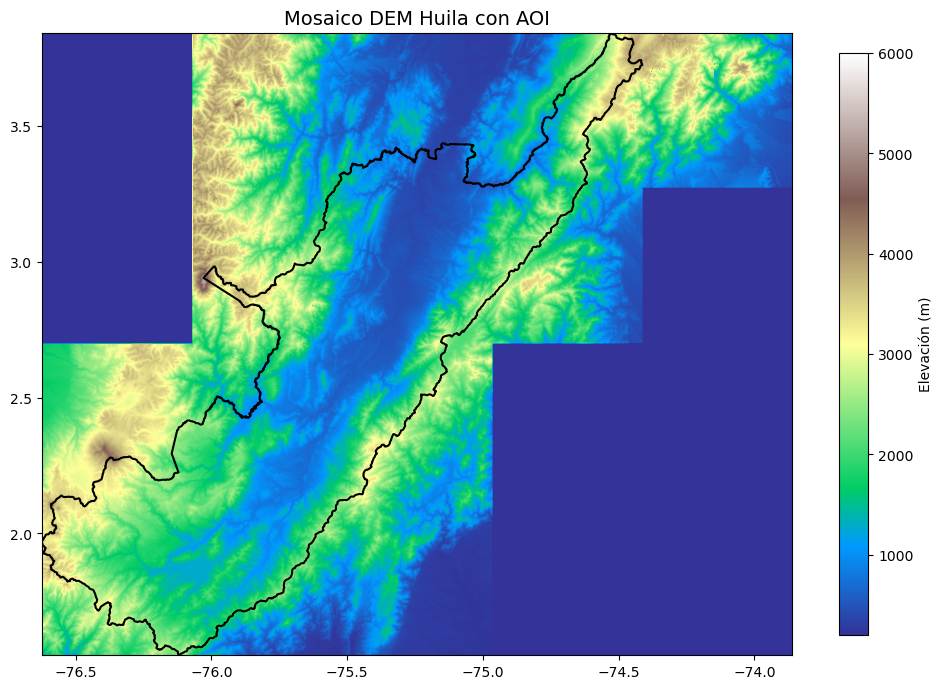

In [191]:
# --- Parámetros de entrada ---
root_folder = r"/notebooks/datos/datos_proyecto"  # Ruta base del proyecto
folder = os.path.join(root_folder, "DEM_Huila")   # Carpeta con los GeoTIFF
tif_files = sorted(glob.glob(os.path.join(folder, "*.tif")))  # Lista de archivos

# --- Cargar y unir los ráster ---
src_files_to_mosaic = [rasterio.open(fp) for fp in tif_files]
mosaic, out_trans = merge(src_files_to_mosaic)

# --- Cargar el polígono del Huila (aoi) ---
# Asegúrate de que la variable `aoi` está previamente cargada como un GeoDataFrame
# y en el mismo CRS que los ráster (usualmente EPSG:4326 o EPSG:9377)
huila_surf = aoi.to_crs(src_files_to_mosaic[0].crs)  # Reproyectar si es necesario

# --- Visualización con polígono y barra de color ---
fig, ax = plt.subplots(figsize=(10, 10))

# Mostrar el mosaico DEM con límites de elevación y estilo
img = show(
    mosaic,
    transform=out_trans,
    ax=ax,
    cmap='terrain',
    vmin=200,
    vmax=6000
)

# Superponer el polígono del Huila
huila_surf.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)

# Título del mapa
plt.title("Mosaico DEM Huila con AOI", fontsize=14)

# Agregar barra de color como leyenda
cbar = plt.cm.ScalarMappable(cmap='terrain')
cbar.set_array([])  # Requerido por matplotlib
cbar.set_clim(200, 6000)
cbar_ax = fig.colorbar(cbar, ax=ax, shrink=0.6, label="Elevación (m)")

# Guardar la figura
plt.savefig("Results/Maps/Mosaico_DEM_Huila.png", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

In [58]:
# Exportando imagen como un sólo archivo mosaico
# Obtener metadatos del primer archivo como referencia
src_ref = src_files_to_mosaic[0]

# Ruta de salida
output_path = os.path.join(root_folder, "DEM_Huila_mos.tif")

# Crear el perfil (metadatos) para el archivo de salida
out_meta = src_ref.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "count": mosaic.shape[0],  # número de bandas (generalmente 1)
    "crs": src_ref.crs
})

# Escribir el archivo
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(mosaic)

print(f"Mosaico guardado correctamente en:\n{output_path}")


Mosaico guardado correctamente en:
/notebooks/datos/datos_proyecto/DEM_Huila_mos.tif


##### **2.3.8 Visualización del Clima**

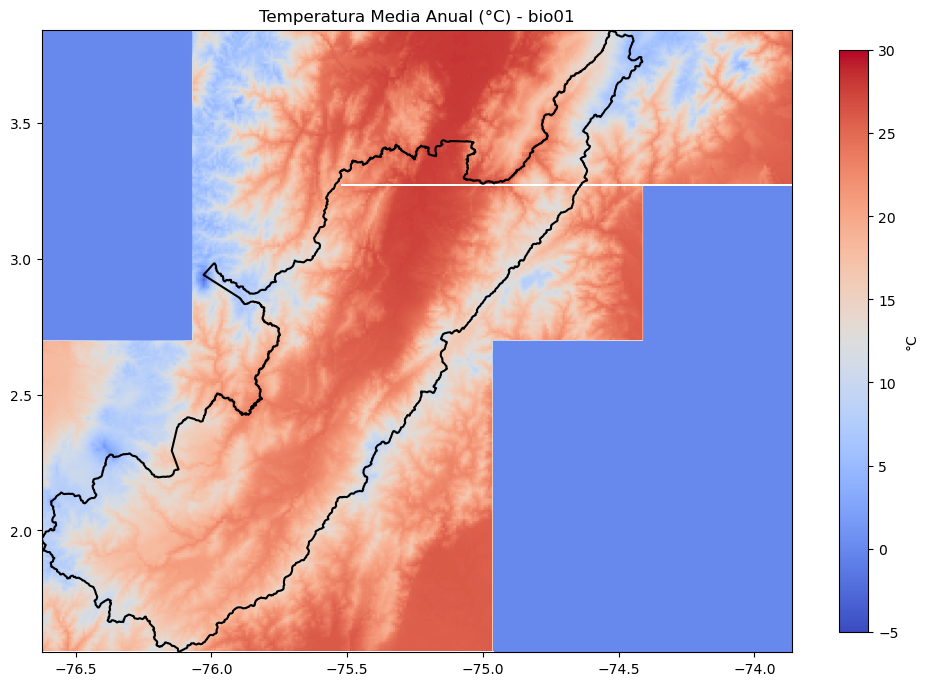

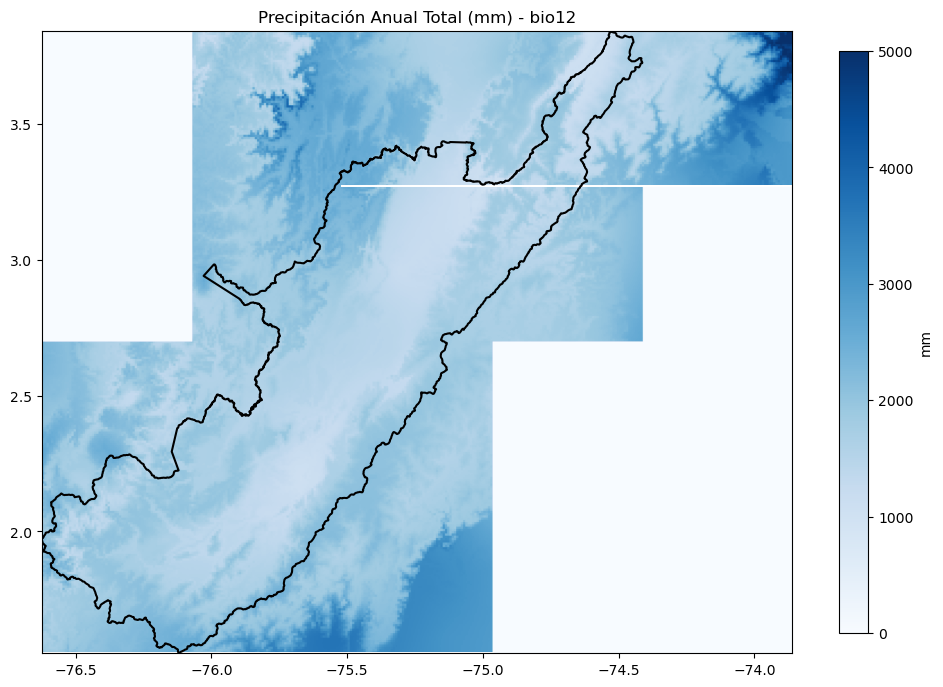

In [192]:
# --- Parámetros de entrada ---
root_folder = r"/notebooks/datos/datos_proyecto"
folder = os.path.join(root_folder, "Clim_Huila")  # Carpeta con los GeoTIFF climáticos
tif_files = sorted(glob.glob(os.path.join(folder, "*.tif")))

# --- Cargar y unir los ráster multibanda ---
src_files_to_mosaic = [rasterio.open(fp) for fp in tif_files]
mosaic, out_trans = merge(src_files_to_mosaic)

# --- Reproyectar AOI al CRS de los ráster ---
huila_proj = aoi.to_crs(src_files_to_mosaic[0].crs)  # `aoi` debe estar cargado como GeoDataFrame

# --- Extraer las bandas ---
bio01 = mosaic[0, :, :] * 0.1    # Temperatura media anual (°C)
bio12 = mosaic[11, :, :] * 1   # Precipitación anual total (mm), con factor 0.1 aplicado

# --- Gráfico 1: Temperatura media anual (bio01) ---
fig1, ax1 = plt.subplots(figsize=(10, 10))
img1 = ax1.imshow(bio01, cmap='coolwarm', extent=(out_trans[2], 
               out_trans[2] + mosaic.shape[2] * out_trans[0],
               out_trans[5] + mosaic.shape[1] * out_trans[4],
               out_trans[5]), vmin=-5, vmax=30)
huila_proj.boundary.plot(ax=ax1, edgecolor='black', linewidth=1.5)
plt.title("Temperatura Media Anual (°C) - bio01")
cbar1 = fig1.colorbar(img1, ax=ax1, shrink=0.6, label="°C")
plt.tight_layout()

# --- Exportar figura 1 ---
plt.savefig("Results/Maps/Temperatura_Huila.png", dpi=300, bbox_inches='tight')

# --- Gráfico 2: Precipitación anual total (bio12) ---
fig2, ax2 = plt.subplots(figsize=(10, 10))
img2 = ax2.imshow(bio12, cmap='Blues', extent=(out_trans[2], 
               out_trans[2] + mosaic.shape[2] * out_trans[0],
               out_trans[5] + mosaic.shape[1] * out_trans[4],
               out_trans[5]), vmin=0, vmax=5000)
huila_proj.boundary.plot(ax=ax2, edgecolor='black', linewidth=1.5)
plt.title("Precipitación Anual Total (mm) - bio12")
cbar2 = fig2.colorbar(img2, ax=ax2, shrink=0.6, label="mm")
plt.tight_layout()
# --- Exportar figura 2 ---
plt.savefig("Results/Maps/Precipitacion_Huila.png", dpi=300, bbox_inches='tight')

plt.show()


##### **2.3.9 Visualización del Clima en histograma**

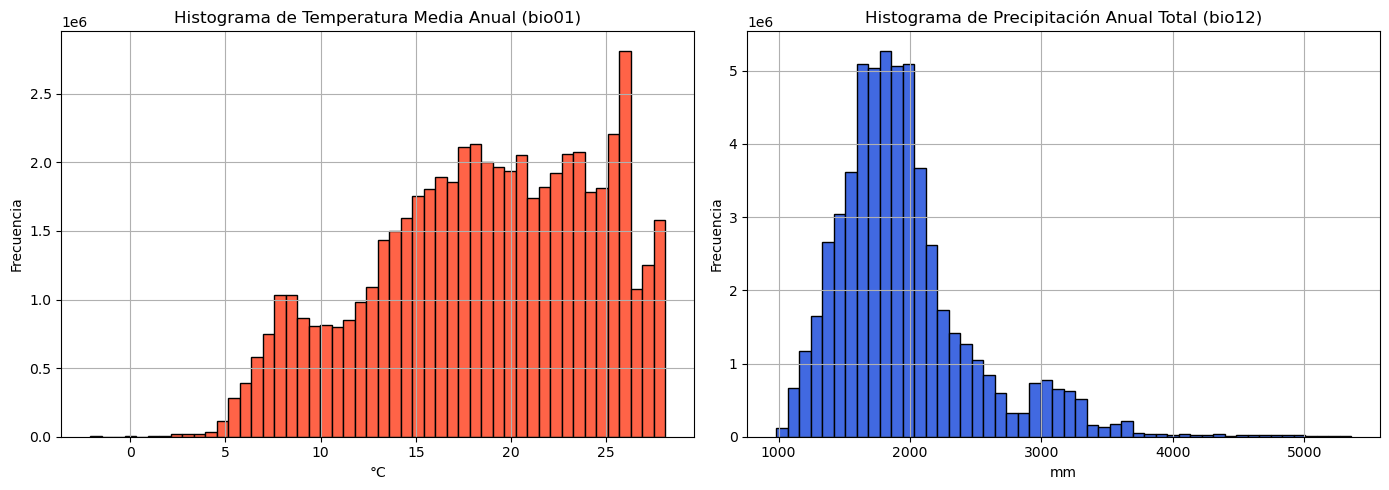

In [193]:
# Preprocesamiento: remover valores no finitos o nulos
bio01_clean = bio01[np.isfinite(bio01)]
bio01_clean = bio01_clean[bio01_clean != 0]

bio12_clean = bio12[np.isfinite(bio12)]
bio12_clean = bio12_clean[bio12_clean != 0]

# Crear subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Histograma bio01
axs[0].hist(bio01_clean.flatten(), bins=50, color='tomato', edgecolor='black')
axs[0].set_title("Histograma de Temperatura Media Anual (bio01)")
axs[0].set_xlabel("°C")
axs[0].set_ylabel("Frecuencia")
axs[0].grid(True)

# Histograma bio12
axs[1].hist(bio12_clean.flatten(), bins=50, color='royalblue', edgecolor='black')
axs[1].set_title("Histograma de Precipitación Anual Total (bio12)")
axs[1].set_xlabel("mm")
axs[1].set_ylabel("Frecuencia")
axs[1].grid(True)

plt.tight_layout()
plt.savefig("Results/Charts/Histogramas_Temp_Preci.png", dpi=300, bbox_inches='tight')
plt.show()

### **3. Ranking de departamentos importantes para Café** 📊
* Se analizarán la producción, rendimiento y área de siembra de Café, para identificar los departamentos más importantes para éste cultivo

#### **3.1 Filtro para Café**
* Creación de un nuevo DataFrame (cafe_eva) que contiene los datos para el cultivo de café para el año 2023.

In [20]:
# Filtro de datos para cultivo de café.
cafe_eva = (df_evas.query('Cultivo == "Café" & Año == 2023').copy())
print("Primeros 5 datos EVAs Café 2023:\n" ,cafe_eva.head())
print("\nTipos de datos EVAs Café 2023:\n" ,cafe_eva.dtypes)

Primeros 5 datos EVAs Café 2023:
      Código Dane departamento Departamento COD_MUNI   Municipio  \
60                          5    Antioquia    05001    Medellín   
428                         5    Antioquia    05004    Abriaquí   
598                         5    Antioquia    05021  Alejandría   
698                         5    Antioquia    05030       Amagá   
806                         5    Antioquia    05031      Amalfi   

    Desagregación cultivo Cultivo Ciclo del cultivo  \
60                   Café    Café        Permanente   
428                  Café    Café        Permanente   
598                  Café    Café        Permanente   
698                  Café    Café        Permanente   
806                  Café    Café        Permanente   

                         Grupo cultivo                           Subgrupo  \
60   Cultivos tropicales tradicionales  Cultivos tropicales tradicionales   
428  Cultivos tropicales tradicionales  Cultivos tropicales tradicionales   
5

#### **3.2 Agrupación de 3 parámetros a analizar**  
Seleccionamos tres distintos parámetros por departamento en un sólo DataFrame, para determinar cuáles son los más importantes:
 - Área sembrada (ha). -> suma
 - Producción (t). -> suma
 - Rendimiento (t/ha). -> promedio
   
**Nota:** Dado que ya se había filtrado por cultivo y por año se suman los primeros parámetros para sacar el total, para el rendimiento se hace un promedio ya que se necesita un valor general del departamento, no es un parámetro que se sume para este análisis.

In [21]:
print("Número de filas:", cafe_eva.shape[0])
cafe_dep = cafe_eva.groupby("Departamento").agg({
    "Área sembrada (ha)": "sum",
    "Producción (t)": "sum",
    "Rendimiento (t/ha)": "mean"
}).reset_index()

cafe_dep.head(32)
top_10_area = cafe_dep.sort_values(by='Área sembrada (ha)', ascending=False).head(10)
top_10_pro = cafe_dep.sort_values(by='Producción (t)', ascending=False).head(10)
top_10_rend = cafe_dep.sort_values(by='Rendimiento (t/ha)', ascending=False).head(10)
top_10_area.head()

Número de filas: 638


,Departamento,Área sembrada (ha),Producción (t),Rendimiento (t/ha)
12,Huila,147991.64,142524.31,1.099143
0,Antioquia,108760.73,95239.75,1.072581
23,Tolima,106837.22,75099.17,0.803421
7,Cauca,94873.60,83603.57,0.979412
4,Caldas,58200.39,50209.35,1.112400


#### **3.3 Comparación de Variables**  
* Elaboramos 3 gráficos de barras diferentes por variable, para analizar los departamentos más importantes para el café.
* El departamento seleccionado es huila, debido que aunque sea de mayor área y mayor producción, apenas es el quinto departamento con mayor rendimiento, lo que brinda una oportunidad de análisis para estudiar áreas que tengan mejores condiciones para aumentar dicho rendimiento.

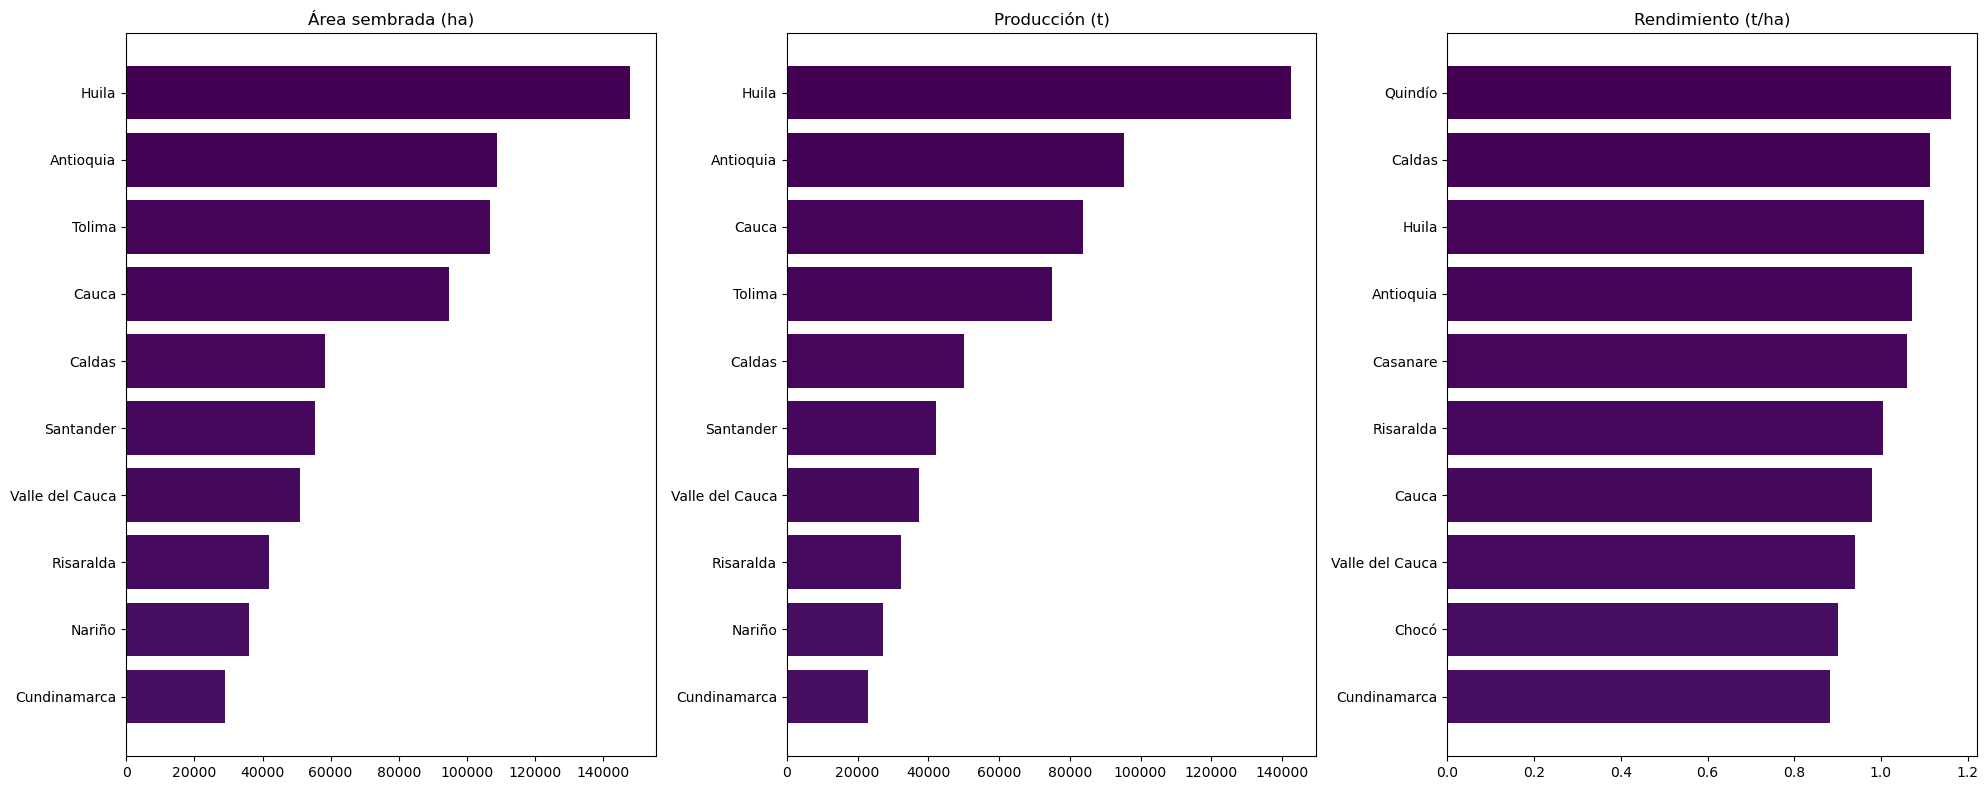

In [194]:
# Crear subgráficos
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), sharey=False)

# Colores opcionales
colors = plt.cm.viridis(range(10))

# Gráfico 1: Área sembrada
axes[0].barh(top_10_area["Departamento"], top_10_area["Área sembrada (ha)"], color=colors)
axes[0].set_title("Área sembrada (ha)")
axes[0].invert_yaxis()  # Para que el primer lugar quede arriba

# Gráfico 2: Producción
axes[1].barh(top_10_pro["Departamento"], top_10_pro["Producción (t)"], color=colors)
axes[1].set_title("Producción (t)")
axes[1].invert_yaxis()

# Gráfico 3: Rendimiento
axes[2].barh(top_10_rend["Departamento"], top_10_rend["Rendimiento (t/ha)"], color=colors)
axes[2].set_title("Rendimiento (t/ha)")
axes[2].invert_yaxis()

# Ajustar diseño
plt.tight_layout()
plt.savefig("Results/Charts/Top10_Departamentos.png", dpi=300, bbox_inches='tight')
plt.show()

### **4. Clasificación por Variables Agronómicas** 
 * Vamos a integrar variables como Profundidad, Textura, Drenaje y Temperatura. Las cuáles son de carácter agronímico. Se compilan en un sólo GeoDataFrame para realizar la primera clasificación.
 * Inicialmente se realiza una visualización de los tipos de textura del estudio de suelos almacenados en `df_inf_suel`

In [23]:
df_inf_suel.head()

,UCS,Profundidad,Drenaje,Textura
0,MEA,Superficial,Bueno,A
1,MHA,Moderadamente profundo,Bueno,FA
2,MHB,Profundo,Bueno,FAr
3,MHC,Profundo,Bueno,FA
4,MKA,Moderadamente profundo,Bueno,FA


#### **4.1 Información de Textura de Suelos.**

* Ahora unimos la capa de suelos con información de textura utilizando como atributo clave = `UCS` visualizados anteriormente, con el `gdf_suelos`

In [37]:
huila_apt = gdf_suelos.merge(df_inf_suel, on="UCS", how="left")
huila_apt.head()

,UCS,UCSf,FASES,PAISAJE,CLIMA_AMBIENTAL,TIPO_RELIEVE,LITOLOGIA,CARACTERISTICAS,COMPONENTES_TAXONOMICOS,PERFILES,PORCENTAJE,AREA_ha,SHAPE_Length,SHAPE_Area,geometry,Profundidad,Drenaje,Textura
0,MQI,MQI,a,Montaña,Templado húmedo y muy húmedo,Vallecitos,Depósitos coluvio - aluviales heterométricos,"Moderadamente profundos, bien drenados, textur...","Asociación: Typic Udifluvents, Typic Eutrudept...",PL-9A; HL-21; HL-62,"50, 35, 15",538.340930,35285.637613,5.383397e+06,"MULTIPOLYGON (((4700273.602 1788150.861, 47003...",Moderadamente profundo,Bueno,F
1,MHC,MHC,"e, f, f2, g2",Montaña,Muy frío húmedo y muy húmedo,Filas y vigas,Mantos de ceniza volcánica sobre materiales íg...,"Son profundos y moderadamente profundos, bien ...","Asociación: Andic Humudepts, Typic Hapludands,...",PS-03; PC-113,"50, 40, 10",546.451314,12238.763923,5.476139e+06,"MULTIPOLYGON (((4608250.525 1787001.291, 46081...",Profundo,Bueno,FA
2,MQE,MQE,"c, d, e",Montaña,Templado húmedo y muy húmedo,Coladas de lodo y lahar,Mantos de ceniza volcánica e ignimbritas y dep...,"Son profundos y muy superficiales, bien drenad...","Asociación: Typic Hapludands, Typic Hapludalfs...","HL-42, PH-31; PG-250; HL-65","45, 35, 20",462.391605,10746.255328,4.626877e+06,"MULTIPOLYGON (((4674883.774 1783541.445, 46747...",Profundo,Bueno,FL
3,MQA,MQA,"e, e2, f, f2, g, g2",Montaña,Templado húmedo y muy húmedo,Filas y vigas,"Materiales ígneo - metamórficos (granitos, ton...","Son profundos, bien drenados, texturas moderad...","Asociación: Andic Dystrudepts, Andic Humudepts...",HL-48; HL-23,"50, 40, 10",1432.747009,33134.823691,1.433122e+07,"MULTIPOLYGON (((4695928.841 1787725.266, 46958...",Profundo,Bueno,FArL
4,MHC,MHC,"e, f, f2, g2",Montaña,Muy frío húmedo y muy húmedo,Filas y vigas,Mantos de ceniza volcánica sobre materiales íg...,"Son profundos y moderadamente profundos, bien ...","Asociación: Andic Humudepts, Typic Hapludands,...",PS-03; PC-113,"50, 40, 10",279.151390,7202.997160,2.797426e+06,"MULTIPOLYGON (((4608935.576 1787606.781, 46088...",Profundo,Bueno,FA


#### **4.2 Clasificación por variable.**  

* Realizamos la clasificación de la aptitud por variable Agronómica:

##### **4.2.1 Profundidad:**
* Inicialmente se exploran las categorías de Profundidad asignada. 
* Luego generamos la clasificación de acuerdo a aptitud.

In [39]:
print(huila_apt["Profundidad"].unique())

['Moderadamente profundo' 'Profundo' 'Superficial' 'Muy superficial' nan]


In [40]:
# Aplicar la clasificación
huila_apt["Apt_profundidad"] = huila_apt["Profundidad"].apply(clasificar_profundidad)

##### **4.2.2 Textura**
* Inicialmente se exploran las categorías de Textura asignada. 
* Luego generamos la clasificación de acuerdo a aptitud.

In [41]:
print(huila_apt["Textura"].unique())

['F' 'FA' 'FL' 'FArL' 'FAr' 'A' 'Ar' 'ArA' nan]


In [42]:
# Aplicar la clasificación
huila_apt["Apt_textura"] = huila_apt["Textura"].apply(clasificar_textura)

##### **4.2.3 Drenaje**
* Inicialmente se exploran las categorías de Drenaje asignada. 
* Luego generamos la clasificación de acuerdo a aptitud.

In [43]:
print(huila_apt["Drenaje"].unique())

['Bueno' 'Imperfecto' 'Moderado' 'Pobre' 'Muy pobre' nan 'Excesivo']


In [44]:
# Aplicar la clasificación
huila_apt["Apt_drenaje"] = huila_apt["Drenaje"].apply(clasificar_drenaje)

##### **4.2.4 Temperatura**
* A partir de la banda _"bio01"_ se asociarán los datos de temperatura con los polígonos creados hasta el momento, el valor para cáda polígono se determinará con la media de estadísticas zonales. 
* Luego se asociarán al GeoDataFrame.
* Finalmente se realiza la clasificación por este parámetro.

In [142]:
# --- Extraer la metadata para reconstruir la banda ---
meta = src_files_to_mosaic[0].meta.copy()
meta.update({
    "count": 1,
    "dtype": rasterio.float32,
    "height": bio01.shape[0],
    "width": bio01.shape[1],
    "transform": out_trans
})

# --- Guardar la capa bio01 en un archivo temporal en memoria ---
with MemoryFile() as memfile:
    with memfile.open(**meta) as dataset:
        dataset.write(bio01.astype(rasterio.float32), 1)
    
    # --- Asegurar mismo CRS ---
    huila_apt_proj = huila_apt.to_crs(dataset.crs)

    # --- Calcular estadísticas zonales ---
    stats = zonal_stats(huila_apt_proj, memfile.name, stats=["mean"], nodata=None)

# --- Asignar resultados al GeoDataFrame ---
huila_apt["temp_mean"] = [s["mean"] for s in stats]

# --- Verifica los primeros resultados ---
print(huila_apt.head())

   UCS UCSf                FASES  PAISAJE               CLIMA_AMBIENTAL  \
0  MQI  MQI                    a  Montaña  Templado húmedo y muy húmedo   
1  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   
2  MQE  MQE              c, d, e  Montaña  Templado húmedo y muy húmedo   
3  MQA  MQA  e, e2, f, f2, g, g2  Montaña  Templado húmedo y muy húmedo   
4  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   

              TIPO_RELIEVE                                          LITOLOGIA  \
0               Vallecitos       Depósitos coluvio - aluviales heterométricos   
1            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   
2  Coladas de lodo y lahar  Mantos de ceniza volcánica e ignimbritas y dep...   
3            Filas y vigas  Materiales ígneo - metamórficos (granitos, ton...   
4            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   

                                     CARACTERISTICAS  \
0  Mod

In [143]:
huila_apt["Apt_temp"] = huila_apt["temp_mean"].apply(clasificar_temperatura)
# --- Verifica los primeros resultados ---
print(huila_apt.head())
huila_apt["Apt_temp"].value_counts()

   UCS UCSf                FASES  PAISAJE               CLIMA_AMBIENTAL  \
0  MQI  MQI                    a  Montaña  Templado húmedo y muy húmedo   
1  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   
2  MQE  MQE              c, d, e  Montaña  Templado húmedo y muy húmedo   
3  MQA  MQA  e, e2, f, f2, g, g2  Montaña  Templado húmedo y muy húmedo   
4  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   

              TIPO_RELIEVE                                          LITOLOGIA  \
0               Vallecitos       Depósitos coluvio - aluviales heterométricos   
1            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   
2  Coladas de lodo y lahar  Mantos de ceniza volcánica e ignimbritas y dep...   
3            Filas y vigas  Materiales ígneo - metamórficos (granitos, ton...   
4            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   

                                     CARACTERISTICAS  \
0  Mod

Apt_temp
N1    635
A2    292
A1    244
A3    231
Name: count, dtype: int64

##### **4.2.5 Precipitación**
* Se repetirá el mismo proceso que se hizo para asociar temperatura, a partir de la banda _"bio12"_ se asociarán los datos de precipitación.

In [144]:
# --- Extraer la metadata para reconstruir la capa bio12 ---
meta = src_files_to_mosaic[0].meta.copy()
meta.update({
    "count": 1,
    "dtype": rasterio.float32,
    "height": bio12.shape[0],
    "width": bio12.shape[1],
    "transform": out_trans
})

# --- Guardar la capa bio12 en un archivo temporal en memoria ---
with MemoryFile() as memfile:
    with memfile.open(**meta) as dataset:
        dataset.write(bio12.astype(rasterio.float32), 1)

    # --- Asegurar mismo CRS para polígonos ---
    huila_apt_proj = huila_apt.to_crs(dataset.crs)

    # --- Calcular estadísticas zonales para bio12 ---
    stats_bio12 = zonal_stats(huila_apt_proj, memfile.name, stats=["mean"], nodata=None)

# --- Asignar los valores promedio al GeoDataFrame original ---
huila_apt["preci_mean"] = [s["mean"] for s in stats_bio12]

# --- Verificar resultados ---
print(huila_apt.head())

   UCS UCSf                FASES  PAISAJE               CLIMA_AMBIENTAL  \
0  MQI  MQI                    a  Montaña  Templado húmedo y muy húmedo   
1  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   
2  MQE  MQE              c, d, e  Montaña  Templado húmedo y muy húmedo   
3  MQA  MQA  e, e2, f, f2, g, g2  Montaña  Templado húmedo y muy húmedo   
4  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   

              TIPO_RELIEVE                                          LITOLOGIA  \
0               Vallecitos       Depósitos coluvio - aluviales heterométricos   
1            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   
2  Coladas de lodo y lahar  Mantos de ceniza volcánica e ignimbritas y dep...   
3            Filas y vigas  Materiales ígneo - metamórficos (granitos, ton...   
4            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   

                                     CARACTERISTICAS  \
0  Mod

##### **4.2.6 Pendiente**
* Calculamos la pendiente a partir del DEM importado desde GEE.
* El raster obtenido se exporta como nuevo archivo .tif en la carpeta de datos.
* Finalmente se representa la imagen raster generada.
* Luego se realiza una clasificación por porcentaje de pendiente.

In [145]:
# Aplicar la clasificación
huila_apt["Apt_preci"] = huila_apt["preci_mean"].apply(clasificar_precipitacion)

# Verificar resultados
print(huila_apt["Apt_preci"].value_counts())
print(huila_apt.head())

Apt_preci
A1    874
A3    528
Name: count, dtype: int64
   UCS UCSf                FASES  PAISAJE               CLIMA_AMBIENTAL  \
0  MQI  MQI                    a  Montaña  Templado húmedo y muy húmedo   
1  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   
2  MQE  MQE              c, d, e  Montaña  Templado húmedo y muy húmedo   
3  MQA  MQA  e, e2, f, f2, g, g2  Montaña  Templado húmedo y muy húmedo   
4  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   

              TIPO_RELIEVE                                          LITOLOGIA  \
0               Vallecitos       Depósitos coluvio - aluviales heterométricos   
1            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   
2  Coladas de lodo y lahar  Mantos de ceniza volcánica e ignimbritas y dep...   
3            Filas y vigas  Materiales ígneo - metamórficos (granitos, ton...   
4            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   

      

In [146]:
input_dem = r"/notebooks/datos/datos_proyecto/DEM_Huila_mos.tif"  # Ruta base del proyecto
slope_output = r"/notebooks/datos/datos_proyecto/slope_percent.tif"

In [147]:
# Calcular la pendiente en porcentaje
cmd = [
    "gdaldem", "slope",
    input_dem,
    slope_output,
    "-s", "111120",       # Factor para convertir grados a metros (aproximado)
    "-compute_edges",
    "-alg", "Horn",       # Algoritmo de Horn
    "-of", "GTiff"
]

print("Pendiente calculada y guardada en:", slope_output)

Pendiente calculada y guardada en: /notebooks/datos/datos_proyecto/slope_percent.tif


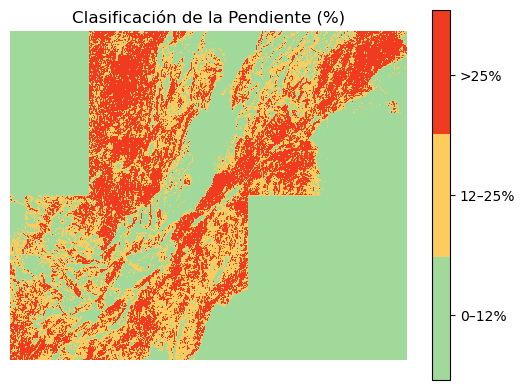

In [195]:
# Leer raster
with rasterio.open(slope_output) as src:
    slope = src.read(1)
    slope[slope == src.nodata] = np.nan

# Clasificar pendiente en 3 rangos
classified = np.where(slope <= 12, 1, np.where(slope <= 25, 2, 3))

# Colores: suave a intenso
colors = ['#a1d99b', '#fecc5c', '#f03b20']
cmap = ListedColormap(colors)

# Visualizar
plt.imshow(classified, cmap=cmap)
cbar = plt.colorbar(ticks=[1.35, 2, 2.65])
cbar.ax.set_yticklabels(['0–12%', '12–25%', '>25%'])
plt.title('Clasificación de la Pendiente (%)')
plt.axis('off')

plt.savefig("Results/Maps/Clasificacion_Pendiente.png", dpi=300, bbox_inches='tight')
plt.show()

In [149]:
# --- Asegurar mismo CRS para polígonos ---
   # huila_apt_proj = huila_apt.to_crs(dataset.crs)

stats = zonal_stats(
    vectors=huila_apt_proj,
    raster=slope_output,
    stats=["median"],
    nodata=0,             # Puedes cambiar esto según el valor nulo de tu raster
    geojson_out=False
)
huila_apt["Pendiente"] = [s["median"] for s in stats]

In [150]:
# --- Aplicar clasificación ---
huila_apt["Apt_pendiente"] = huila_apt["Pendiente"].apply(clasificar_pendiente)
print(huila_apt["Apt_pendiente"].value_counts())
print(huila_apt.head())

Apt_pendiente
A1    1232
A2     167
A3       3
Name: count, dtype: int64
   UCS UCSf                FASES  PAISAJE               CLIMA_AMBIENTAL  \
0  MQI  MQI                    a  Montaña  Templado húmedo y muy húmedo   
1  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   
2  MQE  MQE              c, d, e  Montaña  Templado húmedo y muy húmedo   
3  MQA  MQA  e, e2, f, f2, g, g2  Montaña  Templado húmedo y muy húmedo   
4  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   

              TIPO_RELIEVE                                          LITOLOGIA  \
0               Vallecitos       Depósitos coluvio - aluviales heterométricos   
1            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   
2  Coladas de lodo y lahar  Mantos de ceniza volcánica e ignimbritas y dep...   
3            Filas y vigas  Materiales ígneo - metamórficos (granitos, ton...   
4            Filas y vigas  Mantos de ceniza volcánica sobre materiales

### **5. Clasificación de Logistica**   
Para mejorar la evaluación de suelos se integrarán 2 parámetros que son de importancia al momento de elegir áreas con mayor valor para producir Café:  

* Acceso a Vías.  
* Cercanía a estaciones Meteorológicas.  

#### **5.1 Acceso a vías**
* El objetivo es clasificar los polígonos según su cercanía a las vías principales.
 
##### **5.1.1 Calculo centroide**
* Primero se determina el centroide de cada polígono.

In [152]:
huila_apt["centroid"] = huila_apt.geometry.centroid
print(huila_apt.head())

   UCS UCSf                FASES  PAISAJE               CLIMA_AMBIENTAL  \
0  MQI  MQI                    a  Montaña  Templado húmedo y muy húmedo   
1  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   
2  MQE  MQE              c, d, e  Montaña  Templado húmedo y muy húmedo   
3  MQA  MQA  e, e2, f, f2, g, g2  Montaña  Templado húmedo y muy húmedo   
4  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   

              TIPO_RELIEVE                                          LITOLOGIA  \
0               Vallecitos       Depósitos coluvio - aluviales heterométricos   
1            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   
2  Coladas de lodo y lahar  Mantos de ceniza volcánica e ignimbritas y dep...   
3            Filas y vigas  Materiales ígneo - metamórficos (granitos, ton...   
4            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   

                                     CARACTERISTICAS  \
0  Mod

##### **5.1.2 Filtrado de vías Nacionales para Departamento Huila**

* Primero se genera el polígono general del huila con un `union_all()`.
* Nos aseguramos que este shape se encuentre reporyectado en coordenadas planas (CRS 9377)
* Luego se realiza un filtrado espacial de las vías dentro de dicho polígono del Departamento del huila, se incluye visualización de las estaciones.

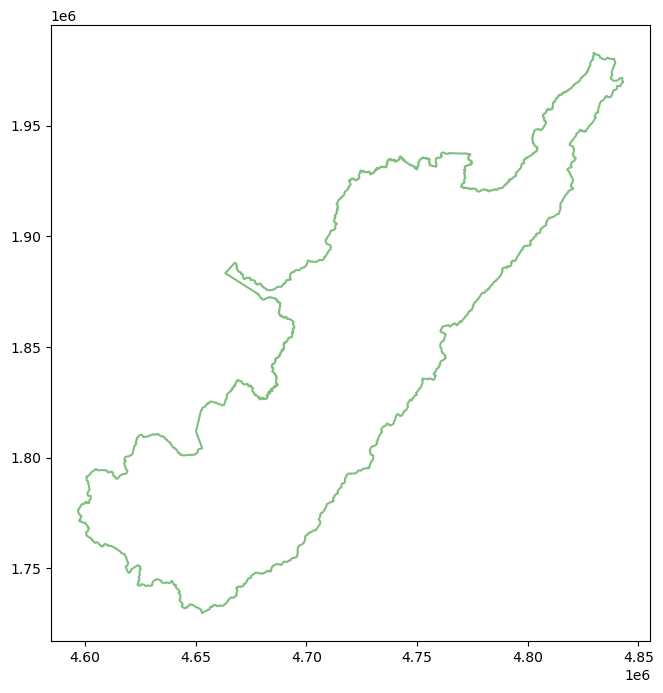

In [153]:
# Generando polígono de Huila, a partir de municipios
zona_es = huila_apt.union_all()
huila = gpd.GeoDataFrame(geometry=[zona_es], crs=9377)
fig, ax = plt.subplots(figsize=(8, 8))
huila.boundary.plot(ax=ax, color='green', alpha=0.5)
plt.show()

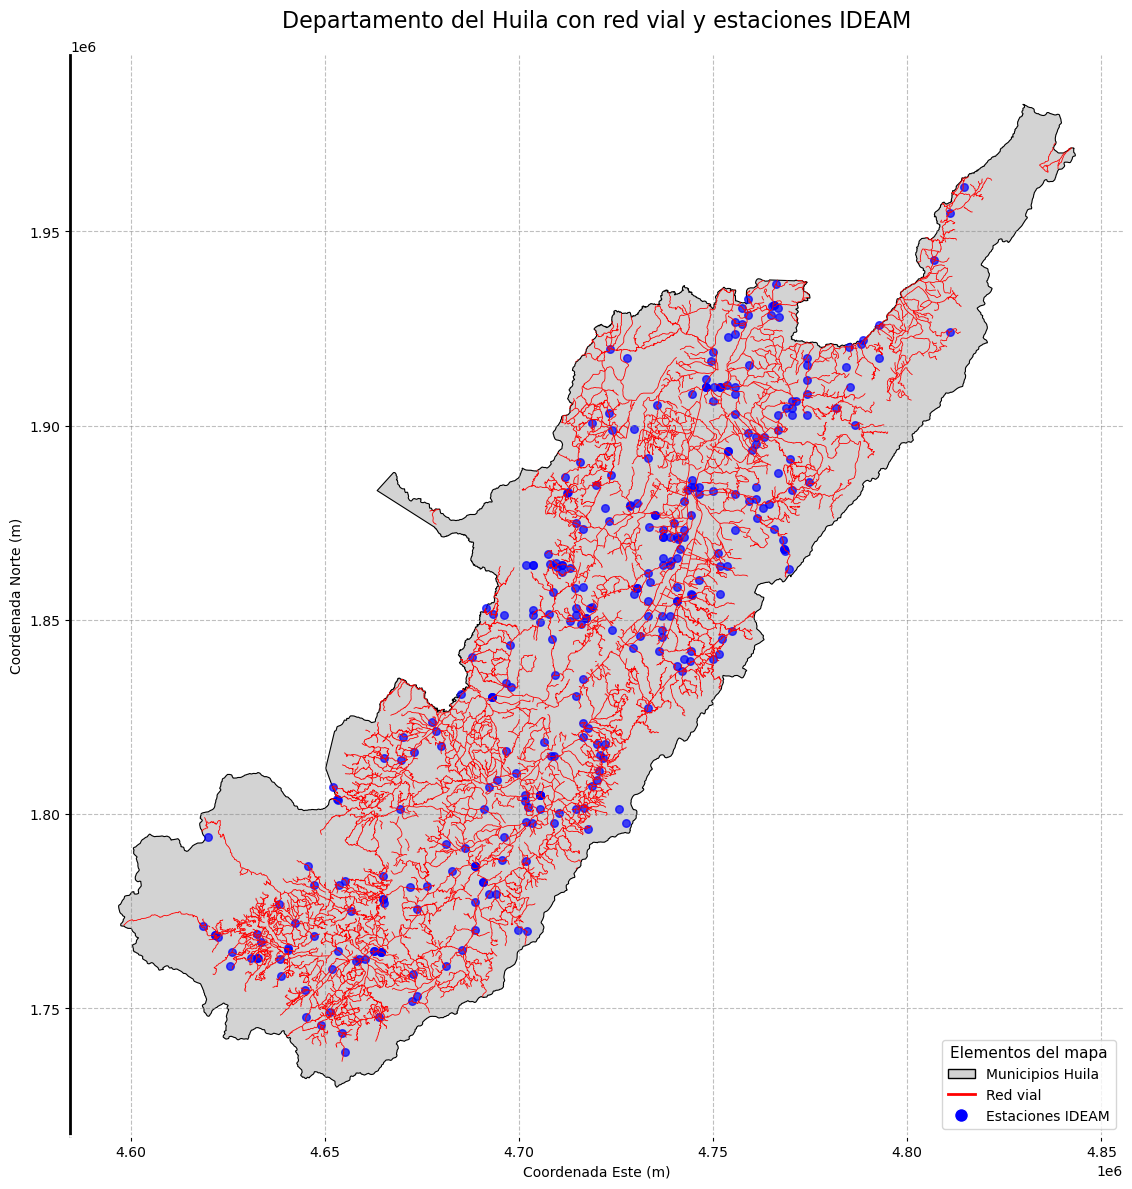

In [196]:
# Filtrar vías y estaciones dentro del Huila
roads_huila_viz = gpd.clip(vias_col, huila)
gdf_est_huila = gdf_est[gdf_est.within(huila.geometry.union_all())]

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(12, 12))

# Dibujar capas
huila.plot(ax=ax, edgecolor="black", facecolor="lightgrey", linewidth=0.8)
roads_huila_viz.plot(ax=ax, color="red", linewidth=0.6)
gdf_est_huila.plot(ax=ax, color="blue", markersize=30, alpha=0.7)

# Título del mapa
ax.set_title("Departamento del Huila con red vial y estaciones IDEAM", fontsize=16, pad=20)

# Mostrar ejes con coordenadas
ax.set_xlabel("Coordenada Este (m)", fontsize=10)
ax.set_ylabel("Coordenada Norte (m)", fontsize=10)

# Activar grilla
ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.5)

# Formato de cebra en los ejes izquierdo e inferior
for i, spine in enumerate(['left', 'bottom']):
    ax.spines[spine].set_linewidth(2)
    ax.spines[spine].set_color('black' if i % 2 == 0 else 'white')

# Ocultar ejes derecho y superior
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Leyenda personalizada
legend_elements = [
    mpatches.Patch(facecolor="lightgrey", edgecolor="black", label="Municipios Huila"),
    Line2D([0], [0], color="red", lw=2, label="Red vial"),
    Line2D([0], [0], marker='o', color='w', label="Estaciones IDEAM",
           markerfacecolor='blue', markersize=10)
]

ax.legend(
    handles=legend_elements,
    title="Elementos del mapa",
    loc="lower right",
    fontsize=10,
    title_fontsize=11,
    frameon=True,
    facecolor='white'
)

# Ajustar disposición final
plt.tight_layout()
plt.savefig("Results/Maps/Red_vial_Estaciones_Huila.png", dpi=300, bbox_inches='tight')
plt.show()


##### **5.1.3 Cálculo de distancia a vía mas cercana**
* Calculamos la distancia más corta que existe entre una vía y el centroide de los polígonos generados.
* Se visualizan los cuartiles para generar los rangos y asignar las etiquetas de clasificación.

In [155]:
# Calcular la distancia mínima desde cada centroide a la geometría de las vías
huila_apt["dist_to_road_km"] = huila_apt["centroid"].apply(
    lambda pt: roads_huila_viz.distance(pt).min() / 1000  # Convertir a kilómetros
)

# Verifica el resultado
huila_apt[["dist_to_road_km"]].head()

,dist_to_road_km
0,0.154076
1,10.608967
2,0.143288
3,0.444443
4,12.853441


In [156]:
# Calcular los cuartiles y el valor máximo
cuartiles = huila_apt["dist_to_road_km"].quantile([0.25, 0.5, 0.75, 1.0])

# Mostrar los resultados
print("Cuartiles de dist_to_road_km:")
print(f"Q1 (25%): {cuartiles.loc[0.25]:.2f} km")
print(f"Q2 (50% - mediana): {cuartiles.loc[0.5]:.2f} km")
print(f"Q3 (75%): {cuartiles.loc[0.75]:.2f} km")
print(f"Q4 (100% - valor máximo): {cuartiles.loc[1.0]:.2f} km")


Cuartiles de dist_to_road_km:
Q1 (25%): 0.17 km
Q2 (50% - mediana): 0.43 km
Q3 (75%): 0.99 km
Q4 (100% - valor máximo): 17.26 km


##### **5.1.4 Clasificación por cercanía a Vía**
* A partir de los cuartiles se generan rangos para clasificar los polígonos

In [157]:
# Aplicar la función
huila_apt["Apt_road"] = huila_apt["dist_to_road_km"].apply(clasificar_distancia)
print(huila_apt.head())

   UCS UCSf                FASES  PAISAJE               CLIMA_AMBIENTAL  \
0  MQI  MQI                    a  Montaña  Templado húmedo y muy húmedo   
1  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   
2  MQE  MQE              c, d, e  Montaña  Templado húmedo y muy húmedo   
3  MQA  MQA  e, e2, f, f2, g, g2  Montaña  Templado húmedo y muy húmedo   
4  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   

              TIPO_RELIEVE                                          LITOLOGIA  \
0               Vallecitos       Depósitos coluvio - aluviales heterométricos   
1            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   
2  Coladas de lodo y lahar  Mantos de ceniza volcánica e ignimbritas y dep...   
3            Filas y vigas  Materiales ígneo - metamórficos (granitos, ton...   
4            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   

                                     CARACTERISTICAS  \
0  Mod

#### **5.2 Cercanía a Estaciones Meteorológicas**
* El objetivo es clasificar los polígonos según su cercanía a una estación meteorológica

##### **5.2.1 Cálcilo de distancia a estación mas cercana**
* Calculamos la distancia de la estación meteorológica más cercana y el centroide de los polígonos generados.
* Se visualizan los cuartiles para generar los rangos y asignar las etiquetas de clasificación.

In [158]:
# Función para calcular la distancia mínima entre un punto y una colección de geometrías
def distancia_minima(centroide, estaciones):
    nearest_geom = stations_union = gdf_est_huila.union_all()
    punto_mas_cercano = nearest_points(centroide, stations_union)[1]
    return centroide.distance(punto_mas_cercano) / 1000  # en kilómetros

# Calcular distancia para cada centroide
huila_apt["dist_to_station_km"] = huila_apt["centroid"].apply(
    lambda centroide: distancia_minima(centroide, gdf_est_huila)
)

In [159]:
# Calcular cuartiles y el valor máximo (100%)
q0 = huila_apt["dist_to_station_km"].quantile(0.00)  # Mínimo
q1 = huila_apt["dist_to_station_km"].quantile(0.25)
q2 = huila_apt["dist_to_station_km"].quantile(0.50)
q3 = huila_apt["dist_to_station_km"].quantile(0.75)
q4 = huila_apt["dist_to_station_km"].quantile(1.00)  # Máximo (100%)

# Mostrar los resultados
print("Q0 (min):", q0)
print("Q1 (25%):", q1)
print("Q2 (50%):", q2)
print("Q3 (75%):", q3)
print("Q4 (100%):", q4)

Q0 (min): 0.10792698302626616
Q1 (25%): 2.0448223113321857
Q2 (50%): 3.5485096721185414
Q3 (75%): 5.797344753495937
Q4 (100%): 41.39715789007452


##### **5.2.2 Clasificación según cercanía a una Estación Meteorológica**
* Se clasifican los polígonos con base a la distancia que hay a la estación meteorológica más cercana

In [160]:
# --- Aplicar clasificación ---
huila_apt["Apt_estacion"] = huila_apt["dist_to_station_km"].apply(clasificar_distancia_estacion)
print(huila_apt.head())

   UCS UCSf                FASES  PAISAJE               CLIMA_AMBIENTAL  \
0  MQI  MQI                    a  Montaña  Templado húmedo y muy húmedo   
1  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   
2  MQE  MQE              c, d, e  Montaña  Templado húmedo y muy húmedo   
3  MQA  MQA  e, e2, f, f2, g, g2  Montaña  Templado húmedo y muy húmedo   
4  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   

              TIPO_RELIEVE                                          LITOLOGIA  \
0               Vallecitos       Depósitos coluvio - aluviales heterométricos   
1            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   
2  Coladas de lodo y lahar  Mantos de ceniza volcánica e ignimbritas y dep...   
3            Filas y vigas  Materiales ígneo - metamórficos (granitos, ton...   
4            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   

                                     CARACTERISTICAS  \
0  Mod

In [161]:
print(huila_apt.info)

<bound method DataFrame.info of       UCS UCSf                FASES          PAISAJE  \
0     MQI  MQI                    a          Montaña   
1     MHC  MHC         e, f, f2, g2          Montaña   
2     MQE  MQE              c, d, e          Montaña   
3     MQA  MQA  e, e2, f, f2, g, g2          Montaña   
4     MHC  MHC         e, f, f2, g2          Montaña   
...   ...  ...                  ...              ...   
1397   CA   CA      Cuerpos de agua  Cuerpos de agua   
1398   CA   CA      Cuerpos de agua  Cuerpos de agua   
1399   CA   CA      Cuerpos de agua  Cuerpos de agua   
1400   CA   CA      Cuerpos de agua  Cuerpos de agua   
1401   CA   CA      Cuerpos de agua  Cuerpos de agua   

                   CLIMA_AMBIENTAL             TIPO_RELIEVE  \
0     Templado húmedo y muy húmedo               Vallecitos   
1     Muy frío húmedo y muy húmedo            Filas y vigas   
2     Templado húmedo y muy húmedo  Coladas de lodo y lahar   
3     Templado húmedo y muy húmedo         

### **6. Filtrado de áreas protegidas por restricción**   
En este apartado se realizará un filtrado que permita excluir aquellas áreas protegidas y confirmar que las zonas identificadas están destinadas para uso agrícola. Se hará un doble intersección.

* Primero se hará una intersección con los polígonos de frontera agrícola definidas por la UPRA.  
* Posteriormente se intersectarán y eliminarán aquellas zonas que estén dentro de las áreas protegidas por el RUNAP.

In [163]:
# Asegurar que todos estén en el mismo CRS
gdf_frnt_agr = gdf_frnt_agr.to_crs(huila_apt.crs)
gdf_runap = gdf_runap.to_crs(huila_apt.crs)

# --- Evaluar si geometría está completamente fuera del frente agrícola ---
# Se intersectan para detectar las que están dentro
intersect_fa = gpd.overlay(huila_apt, gdf_frnt_agr, how="intersection")
ids_fa = intersect_fa["geometry"].apply(lambda x: x.wkt).tolist()

# Marcar como "sí" si no intersectan
huila_apt["No_Apto_FA"] = huila_apt["geometry"].apply(
    lambda geom: "no" if any(geom.intersects(g) for g in gdf_frnt_agr.geometry) else "sí"
)

# --- Evaluar si geometría intersecta con RUNAP ---
huila_apt["No_Apto_RUNAP"] = huila_apt["geometry"].apply(
    lambda geom: "sí" if any(geom.intersects(g) for g in gdf_runap.geometry) else "no"
)

# --- Ver resultados preliminares ---
print(huila_apt[["No_Apto_FA", "No_Apto_RUNAP"]].value_counts())
print(huila_apt.head())

No_Apto_FA  No_Apto_RUNAP
no          no               988
            sí               256
sí          sí               121
            no                37
Name: count, dtype: int64
   UCS UCSf                FASES  PAISAJE               CLIMA_AMBIENTAL  \
0  MQI  MQI                    a  Montaña  Templado húmedo y muy húmedo   
1  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   
2  MQE  MQE              c, d, e  Montaña  Templado húmedo y muy húmedo   
3  MQA  MQA  e, e2, f, f2, g, g2  Montaña  Templado húmedo y muy húmedo   
4  MHC  MHC         e, f, f2, g2  Montaña  Muy frío húmedo y muy húmedo   

              TIPO_RELIEVE                                          LITOLOGIA  \
0               Vallecitos       Depósitos coluvio - aluviales heterométricos   
1            Filas y vigas  Mantos de ceniza volcánica sobre materiales íg...   
2  Coladas de lodo y lahar  Mantos de ceniza volcánica e ignimbritas y dep...   
3            Filas y vigas  Materiales íg

### **7. Aptitud general de los suelos del Huila**  

En esta última sección se realiza la clasificación general que integra las 8 variables que se evaluaron durante este proyecto. 




* Luego se realiza una visualización rápida de la clasificación de aptitud general
* Finalmente se realiza el mapa de Aptitud de suelo para la producción de Café.

#### **7.1 Visualización de la Aptitud específica**

* Se visualiza de manera resumida cómo está clasificada la aptitud de cada una de la variables que se tomaron en cuenta para el cultivo de café.

In [130]:
print(huila_apt.columns)

Index(['UCS', 'UCSf', 'FASES', 'PAISAJE', 'CLIMA_AMBIENTAL', 'TIPO_RELIEVE',
       'LITOLOGIA', 'CARACTERISTICAS', 'COMPONENTES_TAXONOMICOS', 'PERFILES',
       'PORCENTAJE', 'AREA_ha', 'SHAPE_Length', 'SHAPE_Area', 'geometry',
       'Profundidad', 'Drenaje', 'Textura', 'Apt_profundidad', 'Apt_textura',
       'Apt_drenaje', 'centroid', 'dist_to_road_km', 'Apt_road',
       'dist_to_station_km', 'Apt_estacion', 'bio01_mean', 'Apt_temp',
       'bio12_mean', 'temp_mean', 'preci_mean', 'Apt_preci', 'Pendiente',
       'Apt_pendiente', 'No_Apto_FA', 'No_Apto_RUNAP'],
      dtype='object')


In [185]:
atributos_aptitud = [
    "No_Apto_RUNAP",
    "No_Apto_FA",
    "Apt_pendiente",
    "Apt_preci",
    "Apt_temp",
    "Apt_estacion",
    "Apt_road",
    "Apt_drenaje",
    "Apt_textura",
    "Apt_profundidad"
]

html_output = ""

for campo in atributos_aptitud:
    conteo = huila_apt[campo].value_counts().reset_index()
    conteo.columns = [campo, "Cantidad"]
    html_output += f"""
    <div style='display:inline-block; width: 15.5%; margin: 5px; vertical-align:top; font-size: 85%;'>
        <h4 style="text-align:center;">{campo}</h4>
        {conteo.to_html(index=False)}
    </div>
    """

display(HTML(html_output))


No_Apto_RUNAP,Cantidad
no,1025
sí,377
No_Apto_FA,Cantidad
no,1244
sí,158
Apt_pendiente,Cantidad
A1,1232
A2,167
A3,3
Apt_preci,Cantidad


#### **7.2 Aptitud General para la producción de café en el Huila**

* Luego se agrupan por categoría general:
  | Categoría | Descripción         |
|-----------|---------------------|
| A1        | Aptitud Alta        |
| A2        | Aptitud Media       |
| A3        | Aptitud Baja        |
| NA        | No Apto             |

* Inicialmente se agrupan los polígonos no patos por restricción legal o porque algun parámetro específico lo calificó como no apto.
* Posteriormente se realiza una agrupación general a partir del cálculo de la moda para cada parámetro.

In [167]:
# --- Atributos de entrada ---
atributos_no_apto = ["No_Apto_RUNAP", "No_Apto_FA"]
atributos_aptitud = ["Apt_pendiente", "Apt_preci", "Apt_temp", 
                     "Apt_estacion", "Apt_road", "Apt_drenaje", 
                     "Apt_textura", "Apt_profundidad"]

# --- Aplicar clasificación ---
huila_apt["Apt_Final_Huila"] = huila_apt.apply(calcular_apt_final, axis=1)

# --- Crear nuevo GeoDataFrame con columnas requeridas ---
huila_apt_final = huila_apt[[
    "AREA_ha", "SHAPE_Length", "SHAPE_Area", "geometry", "Apt_Final_Huila"
]].copy()


#### **7.3 Visualización del resumen de la clasificación general**

* Una previa vista de el nuevo GeoDataFrame final, que contiene la cantidad de polígonos por categoría.

In [168]:
print(huila_apt_final.head())

       AREA_ha  SHAPE_Length    SHAPE_Area  \
0   538.340930  35285.637613  5.383397e+06   
1   546.451314  12238.763923  5.476139e+06   
2   462.391605  10746.255328  4.626877e+06   
3  1432.747009  33134.823691  1.433122e+07   
4   279.151390   7202.997160  2.797426e+06   

                                            geometry Apt_Final_Huila  
0  MULTIPOLYGON (((4700273.602 1788150.861, 47003...              A1  
1  MULTIPOLYGON (((4608250.525 1787001.291, 46081...              NA  
2  MULTIPOLYGON (((4674883.774 1783541.445, 46747...              A1  
3  MULTIPOLYGON (((4695928.841 1787725.266, 46958...              A1  
4  MULTIPOLYGON (((4608935.576 1787606.781, 46088...              NA  


In [174]:
print(huila_apt_final["Apt_Final_Huila"].value_counts())

Apt_Final_Huila
NA    788
A1    555
A2     41
A3     18
Name: count, dtype: int64


#### **7.4 Ploteo del Mapa final con la Aptitud del suelo para producción de café en el Huila**

* Una previa vista de el nuevo GeoDataFrame final, que contiene la cantidad de polígonos por categoría.

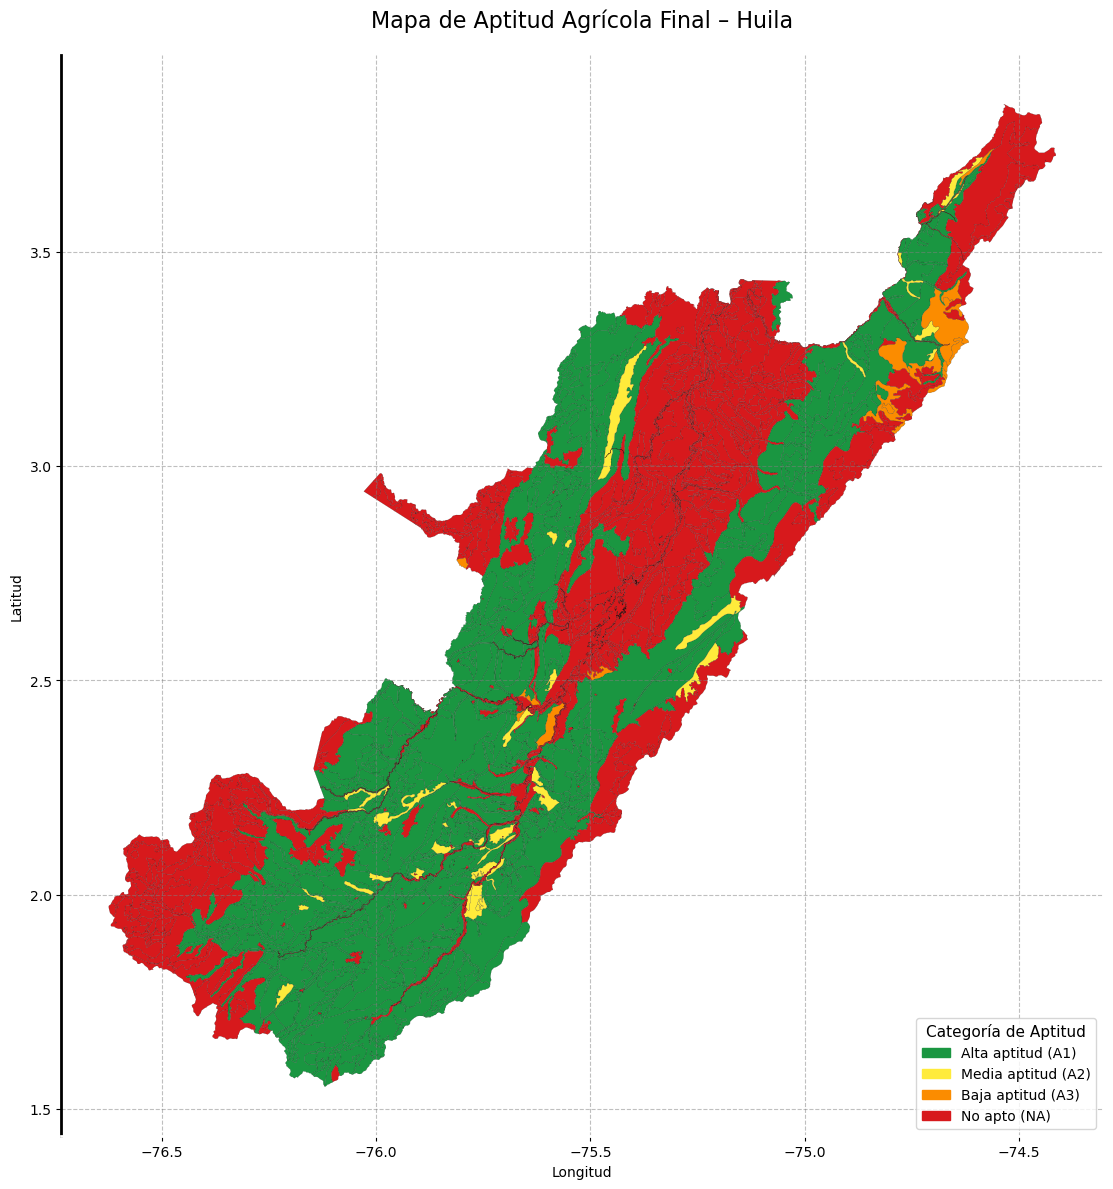

In [197]:
# Asegurarse de estar en EPSG:4326
huila_apt_final = huila_apt_final.to_crs(epsg=4326)

# Colores por categoría y etiquetas
apt_colors = {
    "A1": ("#1a9641", "Alta aptitud (A1)"),     # Verde oscuro
    "A2": ("#ffeb3b", "Media aptitud (A2)"),    # Amarillo
    "A3": ("#fb8c00", "Baja aptitud (A3)"),     # Naranja
    "NA": ("#d7191c", "No apto (NA)")           # Rojo
}

# Crear figura
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Dibujar cada categoría con su color
for cat, (color, label) in apt_colors.items():
    subset = huila_apt_final[huila_apt_final["Apt_Final_Huila"] == cat]
    subset.plot(ax=ax, color=color, edgecolor='black', linewidth=0.1, label=label)

# Leyenda personalizada
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in apt_colors.values()]
ax.legend(
    handles=legend_patches,
    title="Categoría de Aptitud",
    loc='lower right',
    fontsize=10,
    title_fontsize=11,
    frameon=True,
    facecolor='white'
)

# Título
ax.set_title("Mapa de Aptitud Agrícola Final – Huila", fontsize=16, pad=20)

# Mostrar coordenadas geográficas
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.5)

# Formato de cebra en ejes (longitud y latitud alternando color)
for i, spine in enumerate(['left', 'bottom']):
    ax.spines[spine].set_linewidth(2)
    ax.spines[spine].set_color('black' if i % 2 == 0 else 'white')

# Ocultar ejes superior y derecho
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Asegurar buena disposición
plt.tight_layout()
plt.savefig("Results/Maps/Mapa_apt_agríc_final.png", dpi=300, bbox_inches='tight')
plt.show()
